Collect stock and option data, price with BSM, compare accuracy

In [1]:
# !pip install yfinance
# !pip install seaborn

import pandas as pd

from math import sqrt
import numpy as np
from scipy.stats import norm

import seaborn as sns

In [2]:
from datetime import datetime, timezone, timedelta

# exp of Nov 16 2020

timestamp = 1605484800 # exp of Nov 16 2020
# timestamp = 1605657600 # exp of Nov 18 2020

datetime.fromtimestamp(timestamp) # need to add 5 hours (same as UTC)

# create a timestamp for scraping from a given date and time (UTC)
expiration_datetime = datetime(2020, 11, 16, 0, 0, tzinfo=timezone.utc)
expiration_timestamp = int(expiration_datetime.timestamp())
assert expiration_timestamp == 1605484800

Download historical stock price data for SPY. I get a past year's worth from (https://finance.yahoo.com/quote/SPY/history?p=SPY)

In [7]:
# download annual historical data for the stock

stock_price_path = "data/SPY.csv"
df = pd.read_csv(stock_price_path)
df = df.sort_values(by="Date")
df = df.dropna()
# calculate returns
df = df.assign(close_day_before=df.Close.shift(1))
df['returns'] = ((df.Close - df.close_day_before)/df.close_day_before)

# get options data
options_data_path = 'https://finance.yahoo.com/quote/SPY/options?date={}&p=SPY'.format(expiration_timestamp)
r = pd.read_html(options_data_path)[0]
# r = pd.read_html('https://finance.yahoo.com/quote/TSLA/options?p=TSLA&date=1595548800')[0]

In [8]:
print(r)
# print(pd.read_html(options_data_path))

print(df)

         Contract Name         Last Trade Date  Strike  Last Price     Bid  \
0   SPY201116C00170000  2020-11-05 10:02AM EST   170.0      180.47  187.81   
1   SPY201116C00275000   2020-11-02 3:47PM EST   275.0       54.70   82.82   
2   SPY201116C00280000  2020-11-13 11:35AM EST   280.0       75.44   77.82   
3   SPY201116C00285000  2020-11-09 11:42AM EST   285.0       70.85   72.82   
4   SPY201116C00290000  2020-11-13 11:35AM EST   290.0       65.43   67.82   
..                 ...                     ...     ...         ...     ...   
93  SPY201116C00415000   2020-11-06 4:07PM EST   415.0        0.01    0.00   
94  SPY201116C00420000  2020-11-09 11:01AM EST   420.0        0.01    0.00   
95  SPY201116C00430000   2020-10-30 1:24PM EST   430.0        0.01    0.00   
96  SPY201116C00440000   2020-10-19 9:46AM EST   440.0        0.01    0.00   
97  SPY201116C00450000   2020-11-13 3:51PM EST   450.0        0.01    0.00   

       Ask  Change % Change Volume  Open Interest Implied Volat

In [9]:
# S is the spot price 
# K is the strike price 
# T is the fraction of days to strike date divided by 252 (stock market days)
# r is the risk free rate
# sigma is the annual volatility of the returns of the stock 

def black_scholes(S, K, T, r, sigma):
    d1 = np.log(S/(K/(1 + r)**T)/(sigma*sqrt(T))) + (sigma*sqrt(T))/2
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - (K/(1 + r)**T) * norm.cdf(d2)

# get the (num days to expiration) / (trading days in a year)
def get_time_to_expiration(expiration_datetime_utc):
    return (expiration_datetime_utc - datetime.now(timezone.utc)).days / 252


In [10]:
cur_stock_price = 358.04
time_to_expiration = get_time_to_expiration(expiration_datetime)
risk_free_rate = 0.0069
# Calculate the volatility as the annualized standard deviation of the stock returns
sigma = np.sqrt(252) * df['returns'].std()

print(cur_stock_price, time_to_expiration, risk_free_rate, sigma)

list_estimates = []

strike_start_idx, strike_end_idx = 0, 36
# run BSM for different strikes
for x in range(strike_start_idx,strike_end_idx):
    value_s = black_scholes(S = cur_stock_price, 
                            K = r['Strike'][x], 
                            T = (time_to_expiration), 
                            r = risk_free_rate, 
                            sigma = sigma)
    list_estimates.append(value_s)
    
# merge the real and computed dataframes to compare results
df_list = pd.DataFrame(data=list_estimates, index=r.index[strike_start_idx:strike_end_idx])
df_list['estimate'] = df_list[0]
del df_list[0]
df_estimate = r.merge(df_list, right_index = True, left_index = True)

358.04 0.003968253968253968 0.0069 0.3345908911771276


In [11]:
df_estimate

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility,estimate
0,SPY201116C00170000,2020-11-05 10:02AM EST,170.0,180.47,187.81,188.31,0.00,-,-,1,270.31%,188.044305
1,SPY201116C00275000,2020-11-02 3:47PM EST,275.0,54.70,82.82,83.31,0.00,-,-,14,104.69%,83.046493
2,SPY201116C00280000,2020-11-13 11:35AM EST,280.0,75.44,77.82,78.31,3.16,+4.37%,100,130,98.44%,78.046651
3,SPY201116C00285000,2020-11-09 11:42AM EST,285.0,70.85,72.82,73.31,-4.20,-5.60%,100,10,92.19%,73.046820
4,SPY201116C00290000,2020-11-13 11:35AM EST,290.0,65.43,67.82,68.26,2.20,+3.48%,100,200,50.00%,68.047003
5,SPY201116C00295000,2020-11-11 12:27PM EST,295.0,61.94,62.84,63.21,0.00,-,3,3,99.80%,63.047199
6,SPY201116C00300000,2020-10-22 11:41AM EST,300.0,57.27,57.84,58.22,13.87,+31.96%,2,2,92.97%,58.047411
7,SPY201116C00305000,2020-11-11 2:30PM EST,305.0,51.42,52.84,53.22,0.00,-,2,2,85.45%,53.047640
8,SPY201116C00306000,2020-10-30 3:07PM EST,306.0,25.32,51.84,52.22,0.00,-,9,9,83.98%,52.047688
9,SPY201116C00307000,2020-10-30 3:07PM EST,307.0,24.50,50.84,51.22,0.00,-,9,9,82.42%,51.047737


count    36.000000
mean      0.536772
std       0.277757
min       0.141294
25%       0.335814
50%       0.410755
75%       0.668699
max       1.166846
Name: estimate_error, dtype: float64


/home/amao/miniconda3/envs/datasci/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


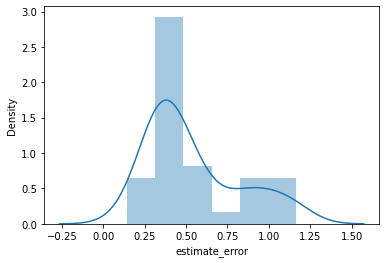

In [12]:
df_estimate['estimate_error'] = ((df_estimate['Ask'] - df_estimate['estimate'])/df_estimate['estimate'])*100

df_estimate['estimate_error'].describe()

ax = sns.distplot(df_estimate['estimate_error'])

print(df_estimate['estimate_error'].describe())